# ActBlue basic details

In [1]:
import json
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
import requests

In [2]:
%matplotlib inline

plt.style.use('ggplot')

In [3]:
def read_or_save(name, func):
    path = 'pickles/' + name + '.pickle.gz'
    if (os.path.isfile(path)):
        return pd.read_pickle(path)
    else:
        result = func()
        os.makedirs('pickles', exist_ok=True)
        result.to_pickle(path)
        return result

In [4]:
committee_id = "C00401224"
year_since = 2013

### Connect to the PostgreSQL database

In [5]:
with open("config.json") as f:
    conf = json.load(f)
conn = psycopg2.connect(
    dbname=conf['dbname'],
    user=conf['user'],
    host=conf['host'],
    password=conf['password']
)

### How many reports are in the database?

In [6]:
read_or_save(
    'filings_count',
    lambda: pd.read_sql("""
    SELECT count(*)
    FROM fec_filings;
    """, con=conn)
)

,count
0,289593


### Which ActBlue reports do we have?

In [7]:
actblue_summaries = read_or_save(
    'actblue_summaries',
    lambda: pd.read_sql("""
    SELECT *
    FROM fec_pac_summaries
    JOIN fec_amended_filings USING (filing_id)
    WHERE filer_committee_id_number = '""" + committee_id + """'
    AND extract(year from coverage_through_date) > """ + str(year_since) + """
    ORDER BY coverage_through_date DESC;
    """, con=conn, parse_dates={
        'coverage_from_date': '%Y-%m-%d',
        'coverage_through_date': '%Y-%m-%d'
    })
)

actblue_summaries[[
    'filing_id',
    'form_type',
    'committee_name',
    'coverage_from_date',
    'coverage_through_date',
    'report_code',
    'col_a_total_contributions'
]]

,filing_id,form_type,committee_name,coverage_from_date,coverage_through_date,report_code,col_a_total_contributions
0,907993,F3XN,ActBlue,2014-01-01,2014-01-31,M2,5.899102e+06
1,912211,F3XN,ActBlue,2014-02-01,2014-02-28,M3,8.488177e+06
2,921401,F3XN,ActBlue,2014-03-01,2014-03-31,M4,1.532761e+07
3,926005,F3XN,ActBlue,2014-04-01,2014-04-30,M5,9.572387e+06
4,932286,F3XN,ActBlue,2014-05-01,2014-05-31,M6,1.110815e+07
5,942637,F3XN,ActBlue,2014-06-01,2014-06-30,M7,1.741317e+07
6,946367,F3XN,ActBlue,2014-07-01,2014-07-31,M8,1.716504e+07
7,952738,F3XN,ActBlue,2014-08-01,2014-08-31,M9,1.982896e+07
8,961472,F3XN,ActBlue,2014-09-01,2014-09-30,M10,3.294525e+07
9,964963,F3XN,ActBlue,2014-10-01,2014-10-15,12G,1.947579e+07


### Are there any reports that FEC.gov has that we don't or vice versa?

In [8]:
def get_reports(committee_id):
    base = "https://api.open.fec.gov/v1/"
    url = base + "committee/" + committee_id + "/reports/?api_key=" + conf['fec_key'] + "&is_amended=False&per_page=100"

    return pd.DataFrame(requests.get(url).json()['results'])

actblue_api_summaries = read_or_save('actblue_api_summaries', lambda: get_reports(committee_id))
pd.to_numeric(actblue_api_summaries['calendar_ytd'])
actblue_api_summaries = actblue_api_summaries[actblue_api_summaries['calendar_ytd'] > year_since]
actblue_api_summaries[['file_number','calendar_ytd']]

pd.DataFrame(pd.concat([actblue_api_summaries['file_number'],
                        actblue_summaries['filing_id']]).drop_duplicates(keep=False))

,0


### How have contributions changed over time?

Text(0.5,1,'Total contributions by reporting period')

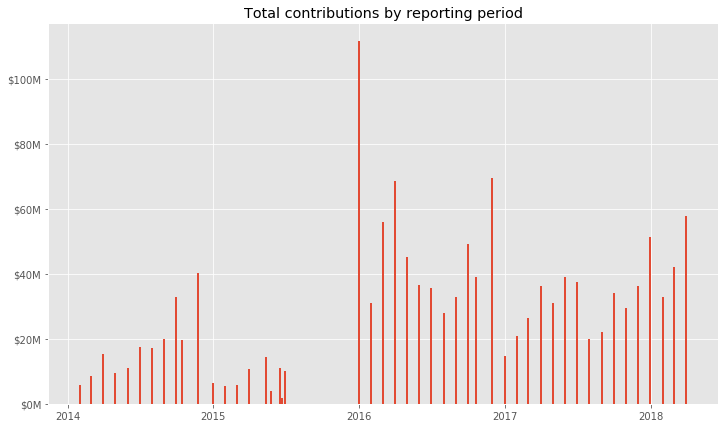

In [9]:
contribs_over_time = actblue_summaries[['coverage_through_date','col_a_total_contributions']]

# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
contribs_over_time.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(12,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_over_time.index, contribs_over_time['col_a_total_contributions'], width=5)

ax.set_title('Total contributions by reporting period')

In [10]:
contribs_by_year = pd.DataFrame(
    actblue_summaries.groupby(actblue_summaries.coverage_through_date.dt.year)['col_a_total_contributions'].sum()
)
contribs_by_year

,col_a_total_contributions
coverage_through_date,
2014,2.037183e+08
2015,1.745485e+08
2016,5.053595e+08
2017,3.838292e+08
2018,1.326956e+08


Text(0.5,1,'Total contributions by year')

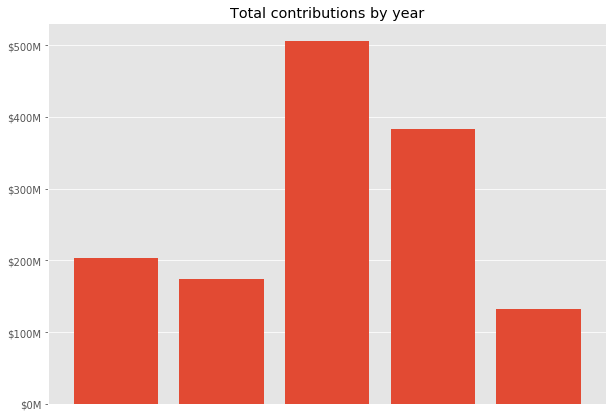

In [11]:
# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
# contribs_by_year.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(10,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_by_year.index, contribs_by_year['col_a_total_contributions'], width=0.8)

ax.set_title('Total contributions by year')

### How many Democratic campaigns use ActBlue?

In [15]:
actblue_transfers = read_or_save(
    'actblue_transfers',
    lambda: pd.read_sql("""
    SELECT fec_committees.name,
           totals.*
    FROM
      (SELECT beneficiary_committee_fec_id,
              count(*),
              sum(expenditure_amount)
       FROM fec_expenditures
       WHERE filing_id IN
           (SELECT filing_id
            FROM fec_pac_summaries
            JOIN fec_amended_filings USING (filing_id)
            WHERE filer_committee_id_number = '""" + committee_id + """'
              AND extract(YEAR
                          FROM coverage_through_date) > """ + str(year_since) + """
            ORDER BY coverage_through_date DESC)
         AND form_type = 'SB23'
       GROUP BY beneficiary_committee_fec_id) AS totals
    JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id
    """, con=conn)
)
actblue_transfers.sort_values(by=['sum'], ascending=False)

,name,beneficiary_committee_fec_id,count,sum
1742,DCCC,C00000935,8893144,1.848996e+08
897,BERNIE 2016,C00577130,6955993,1.808988e+08
335,DSCC,C00042366,2682179,7.556586e+07
512,END CITIZENS UNITED,C00573261,2983274,4.071421e+07
467,PROGRESSIVE TURNOUT PROJECT,C00580068,1095885,1.480668e+07
564,GILLIBRAND FOR SENATE,C00413914,319137,1.246245e+07
273,CHC BOLD PAC,C00365536,798430,1.072173e+07
1720,AMERICANS FOR RESPONSIBLE SOLUTIONS-PAC,C00540443,337414,9.547589e+06
577,MAGGIE FOR NH,C00588772,315756,9.541048e+06
414,CATHERINE CORTEZ MASTO FOR SENATE,C00575548,372082,9.471479e+06


### Questions to answer
> - How many Democratic campaigns are reporting using ActBlue? Does it essentially have a monopoly on the D side?
> - What percent of Democratic candidate dollars so far this cycle have come through ActBlue?
> - Are Republican groups reporting any small donor data that we could analyze in a valid way, or is that just impossible?
> - Is this fueling primary fights?
